## Understanding and Predicting Property Maintenance Fines

The Michigan Data Science Team ([MDST](http://midas.umich.edu/mdst/)) and the Michigan Student Symposium for Interdisciplinary Statistical Sciences ([MSSISS](https://sites.lsa.umich.edu/mssiss/)) have partnered with the City of Detroit to help solve one of the most pressing problems facing Detroit - blight. [Blight violations](http://www.detroitmi.gov/How-Do-I/Report/Blight-Complaint-FAQs) are issued by the city to individuals who allow their properties to remain in a deteriorated condition. Every year, the city of Detroit issues millions of dollars in fines to residents and every year, many of these fines remain unpaid. Enforcing unpaid blight fines is a costly and tedious process, so the city wants to know: how can we increase blight ticket compliance?

The first step in answering this question is understanding when and why a resident might fail to comply with a blight ticket. We need to predict whether a given blight ticket will be paid on time.

All data used here is pulled from the [Detroit Open Data Portal](https://data.detroitmi.gov/).

___

We provide you with two data files for use in training and validating your models: train.csv and test.csv. Each row in these two files corresponds to a single blight ticket, and includes information about when, why, and to whom each ticket was issued. The target variable is compliance, which is True if the ticket was paid early, on time, or within one month of the hearing data, False if the ticket was paid after the hearing date or not at all, and Null if the violator was found not responsible. Compliance, as well as a handful of other variables that will not be available at test-time, are only included in train.csv.

Note: All tickets where the violators were found not responsible are not considered during evaluation. They are included in the training set as an additional source of data for visualization, and to enable unsupervised and semi-supervised approaches. However, they are not included in the test set.

<br>

**File descriptions** (Use only this data for training your model!)

    train.csv - the training set (all tickets issued 2004-2011)
    test.csv - the test set (all tickets issued 2012-2016)
    addresses.csv & latlons.csv - mapping from ticket id to addresses, and from addresses to lat/lon coordinates. 
     Note: misspelled addresses may be incorrectly geolocated.

<br>

**Data fields**

train.csv & test.csv

    ticket_id - unique identifier for tickets
    agency_name - Agency that issued the ticket
    inspector_name - Name of inspector that issued the ticket
    violator_name - Name of the person/organization that the ticket was issued to
    violation_street_number, violation_street_name, violation_zip_code - Address where the violation occurred
    mailing_address_str_number, mailing_address_str_name, city, state, zip_code, non_us_str_code, country - Mailing address of the violator
    ticket_issued_date - Date and time the ticket was issued
    hearing_date - Date and time the violator's hearing was scheduled
    violation_code, violation_description - Type of violation
    disposition - Judgment and judgement type
    fine_amount - Violation fine amount, excluding fees
    admin_fee - $20 fee assigned to responsible judgments
state_fee - $10 fee assigned to responsible judgments
    late_fee - 10% fee assigned to responsible judgments
    discount_amount - discount applied, if any
    clean_up_cost - DPW clean-up or graffiti removal cost
    judgment_amount - Sum of all fines and fees
    grafitti_status - Flag for graffiti violations
    
train.csv only

    payment_amount - Amount paid, if any
    payment_date - Date payment was made, if it was received
    payment_status - Current payment status as of Feb 1 2017
    balance_due - Fines and fees still owed
    collection_status - Flag for payments in collections
    compliance [target variable for prediction] 
     Null = Not responsible
     0 = Responsible, non-compliant
     1 = Responsible, compliant
    compliance_detail - More information on why each ticket was marked compliant or non-compliant


___

## Evaluation

Your predictions will be given as the probability that the corresponding blight ticket will be paid on time.

The evaluation metric for this assignment is the Area Under the ROC Curve (AUC). 

___

We create a function that trains a model to predict blight ticket compliance in Detroit using `train.csv`. Using this model, return a series of length 61001 with the data being the probability that each corresponding ticket from `test.csv` will be paid, and the index being the ticket_id.

**Note**:

From the training of the model, "compliance_detail" and "collection_status" should be removed to prevent data leakage because these variables already imply that someone is compliant or not.

In [1]:
import pandas as pd
import numpy as np
from operator import itemgetter

In [55]:
# Fine tuning: Step 1

def clean_df():
    
    df_train = pd.read_csv('../datasets/train.csv', engine='python')
    #df_train = pd.read_csv('../datasets/train.csv',  encoding = 'ISO-8859-1') #also works
    
    df_test = pd.read_csv('../datasets/test.csv', engine='python') #encoding = 'ISO-8859-1')
    df_test = df_test.replace({'disposition' : {'Responsible - Compl/Adj by Default' : 'Responsible by Default', 
                                  'Responsible - Compl/Adj by Determi' : 'Responsible by Determination', 
                                  'Responsible by Dismissal' : 'Responsible by Admission', 
                                  'Responsible (Fine Waived) by Admis' : 'Responsible (Fine Waived) by Deter'}})
    
    addresses = pd.read_csv('../datasets/addresses.csv', engine='python') 
    latlons = pd.read_csv('../datasets/latlons.csv', engine='python') 
    
#    df_train['violation_code'] = df_train['violation_code'].apply(lambda x: x[:x.find(' (')])
    
#    df_train['violation_code'].replace(r'\(.*|\s.*','', regex=True, inplace=True)
#    df_test['violation_code'].replace(r'\(.*|\s.*','', regex=True, inplace=True)

    
    
    # this finds the number of unique values for each column
    unique_counts = df_train.apply(pd.Series.nunique)
    # does the same job
    #value_count_counts = (df_drop.apply(pd.Series.value_counts)).apply(pd.Series.count)
    
    mask = addresses['ticket_id'].isin(list(df_train['ticket_id']))
    df_train = pd.merge(addresses[mask], df_train, on='ticket_id')
    mask = latlons['address'].isin(list(df_train['address']))
    df_train = pd.merge(latlons[mask], df_train, on='address')
    
    
    mask = addresses['ticket_id'].isin(list(df_test['ticket_id']))
    df_test = pd.merge(addresses[mask], df_test, on='ticket_id')
    mask = latlons['address'].isin(list(df_test['address']))
    df_test = pd.merge(latlons[mask], df_test, on='address')
    
    
    
#    df_train = df_train[(df_train['country']=='USA') & (df_train['state']=='MI')]
    cols_to_keep = ['disposition', 'lat', 'lon', 'violation_code', #'zip_code', 
                'fine_amount', 'late_fee', 'discount_amount', 'judgment_amount', 'compliance']
    to_dummies = ['disposition', 'violation_code']#,'zip_code']
    
    
#    mask = df_train['violation_code'].isin(list(df_test['violation_code']))
#    df_train = df[mask]
#    mask = df_test['violation_code'].isin(list(df_train['violation_code']))
#    df_test = df_test[mask]



    df_train = df_train[cols_to_keep]
   # df_train['zip_code'] = df_train['zip_code'].str[:5]
    df_train.dropna(inplace=True)
    

    df_tst = df_test[cols_to_keep[:-1]].copy()
   # df_tst['zip_code'] = df_tst['zip_code'].str[:5]
    df_tst.fillna(df_tst.median(), inplace=True)
    df_tst = pd.get_dummies(df_tst, prefix=to_dummies, columns=to_dummies)


    df_train = pd.get_dummies(df_train, prefix=to_dummies, columns=to_dummies)

    for var in to_dummies:
        df_train.drop(df_train.columns[df_train.columns.str.startswith(var)][0], axis=1, inplace=True)
        df_tst.drop(df_tst.columns[df_tst.columns.str.startswith(var)][0], axis=1, inplace=True)

    
    df_y_train = df_train['compliance']
    df_train = df_train.loc[:, ~df_train.columns.str.contains('compliance')]

    
    # this line of code stardardizes columns in both sets, in the sense that both will have the same columns
    df_train, df_tst = df_train.align(df_tst, axis=1, fill_value=0) 
    
    return df_train, df_y_train, df_tst, df_test['ticket_id']

In [56]:
# Fine tuning: Step 2

def preprocessed_df(x=clean_df()[:3], train_size=0.75):
    
    df_train = x[0]
    df_y_train = x[1]
    df_tst = x[2]

    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(df_train, df_y_train, train_size = train_size, random_state=0)
    
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    df_tst = scaler.transform(df_tst)
    
    return X_train, X_test, y_train, y_test, df_tst

In [57]:
# Fine tuning: Step 3

X_train, X_test, y_train, y_test, df_tst = preprocessed_df(train_size=0.1)
arrays_for_tuning = preprocessed_df((X_train, y_train, df_tst))[:4]
arrays_for_testing = preprocessed_df((X_test, y_test, df_tst))[:4]

In [72]:
# Fine tuning: Step 4

def my_GBC(x=preprocessed_df()[:4]):
    
    X_train = x[0]
    X_test = x[1]
    y_train = x[2]
    y_test = x[3]
    
    from sklearn.ensemble import GradientBoostingClassifier
    clf = GradientBoostingClassifier(learning_rate=0.005, min_samples_leaf=55, max_depth=5, 
                                     min_samples_split=1000, n_estimators=1000, 
                                     max_features=110 #7 #24, subsample=1.0
                                    ).fit(X_train, y_train)

    from sklearn.metrics import roc_auc_score
    print('ROC AUC of Gradient Boost Classifier (Train): ', roc_auc_score(y_train, clf.predict_proba(X_train)[:,1]))
    print('ROC AUC of Gradient Boost Classifier (Test): ', roc_auc_score(y_test, clf.predict_proba(X_test)[:,1]))
    
    return clf

#my_GBC();

In [73]:
# Fine tuning: Step 5, 8, etc. until optimal parameters are reached

clf = my_GBC(arrays_for_tuning);

#0.8171319136276868
#0.8194713703712886 learning_rate=0.0125, n_estimators=480
#0.8177438414689575
#0.8183495715265554 learning_rate=0.01, n_estimators=1000

ROC AUC of Gradient Boost Classifier (Train):  0.840238729711097
ROC AUC of Gradient Boost Classifier (Test):  0.8149593838576659


In [83]:
# Fine tuning: Step 6, 9, etc. until optimal parameters are reached

def find_best_params(clf, X_train, y_train, grid_values):
    
    from sklearn.model_selection import GridSearchCV
    
    grid_clf = GridSearchCV(clf, param_grid=grid_values, scoring = 'roc_auc', cv=3).fit(X_train, y_train)
#    means = grid_clf.cv_results_['mean_test_score']
#    for mean, params in zip(means, grid_clf.cv_results_['params']):
#        print("%0.3f for %r" % (mean, params))
    
    return grid_clf, grid_clf.best_params_






def param_tuning():
    X_train, y_train = itemgetter(0, 2)(arrays_for_tuning)
    grid_values_GBC = {'max_depth':range(11,16,2)}
    
    
    #{'min_samples_split':range(1000,1101,50)}    
    #{'min_samples_leaf':range(50,60,5)}
    #{'max_features':range(105,116,5)}
    
    #{'subsample':[0.6,0.7,0.75,0.8,0.85,0.9]}
    #{'max_features':range(23,25)}
    #{'max_features':range(18,30,2)}
    #{'max_features':range(7,20,2)}
    #{'min_samples_leaf':range(30,71,10)}
    #{'max_depth':range(2,6)}
    #{'max_depth':range(5,16,2), 'min_samples_split':range(200,1001,200)}
    #{'n_estimators':range(20,100,10)}
    #{'learning_rate': [0.001, 0.01, 0.1]}
    
    return find_best_params(clf, X_train, y_train, grid_values_GBC)

#    grid_values_Logit = {'C':[0.01, 0.1, 1, 10, 100]}
#    return find_best_params(my_logit(), X_train, y_train, grid_values_Logit)


grid_clf, best_params = param_tuning()
print(best_params)



{'max_depth': 13}


GBC so far:


Model Report
Accuracy : 0.9326
AUC Score (Train): 0.811824
CV Score : Mean - 0.8062559 | Std - 0.01365896 | Min - 0.7825243 | Max - 0.8205036


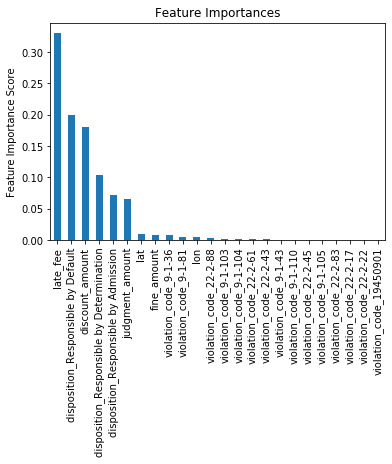

In [20]:
# Fine tuning: Step 7, 10, etc. until optimal parameters are reached
# this step acts as a sanity check and visualize how well the tuning is going

def modelfit_plot(clf, arrays_for_tuning, cv_folds=5):
    
    from sklearn.metrics import accuracy_score, roc_auc_score
    from sklearn.model_selection import cross_val_score
    import matplotlib.pyplot as plt
    
    X_train = arrays_for_tuning[0]
    y_train = arrays_for_tuning[2]
    
    #Fit the algorithm on the data
    clf.fit(X_train, y_train)
            
    #Predict training set:
    X_train_predictions = clf.predict(X_train)
    X_train_predprob = clf.predict_proba(X_train)[:,1]
    
    #Perform cross-validation:
    cv_score = cross_val_score(clf, X_train, y_train, cv=cv_folds, scoring='roc_auc')
    
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % accuracy_score(y_train.values, X_train_predictions))
    print("AUC Score (Train): %f" % roc_auc_score(y_train, X_train_predprob))
    
    print("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),
                                                                             np.std(cv_score),
                                                                             np.min(cv_score),
                                                                             np.max(cv_score)))
    
    
    feat_imp = pd.Series(clf.feature_importances_, clean_df()[0].columns).sort_values(ascending=False)
    feat_imp = feat_imp[feat_imp>0]
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')


print('GBC so far:')
modelfit_plot(clf, arrays_for_tuning)

#Model Report
#Accuracy : 0.9276
#AUC Score (Train): 0.810152
#CV Score : Mean - 0.8044508 | Std - 0.02028369 | Min - 0.7690659 | Max - 0.8287831

GBC with the best parameter values:


Model Report
Accuracy : 0.9343
AUC Score (Train): 0.813625
CV Score : Mean - 0.807501 | Std - 0.01312535 | Min - 0.7841887 | Max - 0.8214932
The best estimator:  GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.0125, loss='deviance', max_depth=3,
                           max_features=9, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=50, min_samples_split=800,
                           min_weight_fraction_leaf=0.0, n_estimators=460,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)


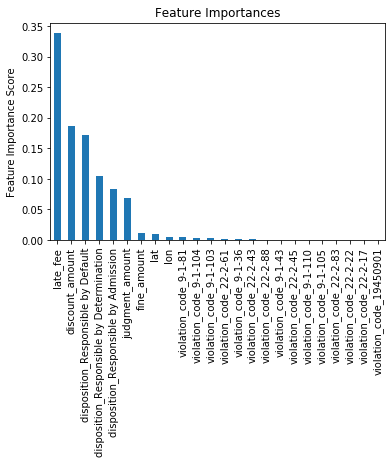

In [22]:
print('GBC with the best parameter values:\n')
modelfit_plot(grid_clf.best_estimator_, arrays_for_tuning)
print('The best estimator: ', grid_clf.best_estimator_)

GBC with the best parameter values:


Model Report
Accuracy : 0.9343
AUC Score (Train): 0.813625
CV Score : Mean - 0.807501 | Std - 0.01312535 | Min - 0.7841887 | Max - 0.8214932
The best estimator:  GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.0125, loss='deviance', max_depth=3,
                           max_features=9, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=50, min_samples_split=800,
                           min_weight_fraction_leaf=0.0, n_estimators=460,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)


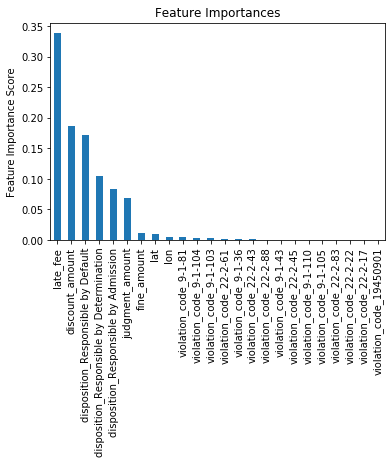

In [22]:
print('GBC with the best parameter values:\n')
modelfit_plot(grid_clf.best_estimator_, arrays_for_tuning)
print('The best estimator: ', grid_clf.best_estimator_)

In [ ]:
# The final testing phase:
my_GBC(arrays_for_testing);

### Logistic Regression

In [11]:
def my_logit(x=preprocessed_df()[:4]):
    
    X_train = x[0]
    X_test = x[1]
    y_train = x[2]
    y_test = x[3]

    from sklearn.linear_model import LogisticRegression
    clf = LogisticRegression(solver='liblinear', C=100, random_state=0).fit(X_train, y_train)

    from sklearn.metrics import roc_auc_score
    print('ROC AUC of Logistic Regression: ', roc_auc_score(y_test, clf.decision_function(X_test)))
    
    return clf

my_logit();

ROC AUC of Logistic Regression:  0.792483892872601


In [ ]:
def optimal_features_df(clf=my_logit(),x=preprocessed_df()):
    
    X = np.concatenate([x[0],x[1]],axis=0)
    y = np.concatenate([x[2],x[3]],axis=0)
    df_tst = x[4]
    
#    from sklearn.model_selection import StratifiedKFold
    from sklearn.feature_selection import RFECV
    
    rfecv = RFECV(estimator=clf, step=1, cv=3, scoring='roc_auc').fit(x[0], x[2])
    print('Optimal number of features: {}'.format(rfecv.n_features_))
    
    X = X.drop(X.columns[np.where(rfecv.support_ == False)[0]], axis=1)
    df_tst = df_tst.drop(df_tst.columns[np.where(rfecv.support_ == False)[0]], axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
    
    return X_train, X_test, y_train, y_test, df_tst

#my_logit(optimal_features_df()[:4])

In [12]:
def blight_model(clf=my_logit(),df_tst=preprocessed_df()[4],index=clean_df()[3]):

    output = pd.Series(clf.predict_proba(df_tst)[:,1],index=index)

    return output

#blight_model()[:3]
blight_model(my_GBC(arrays_for_testing))[:3]

# AUC: 0.781002145583     on the test.csv dataset on the server
# AUC: 0.7912867185325285 on my test set

# AUC: 0.775248850108     on the test.csv dataset on the server (with violations_code)
# AUC: 0.7967995598679135 on my test set (with violations_code)

# AUC: 0.779532715908     on the test.csv dataset on the server (with lat, lon data)
# AUC: 0.7876908991739616 on my test set (with lat, lon data)

# AUC: 0.781305546359     on the server (deleting the restriction of the dataset to MI, USA)
# AUC: 0.7832505511352577 on my test set

# AUC: 0.759038141786     on the server (only float input; without disposition)
# AUC: 0.7526468770146029 on my test set

# AUC: 0.759575490389     on the server (with only 'fine_amount', 'late_fee', 'discount_amount')
# AUC: 0.751981622122613  on my test set

# AUC: 0.757010348822     on the server (with only 'fine_amount', 'late_fee')
# AUC: 0.7495757746911171 on my test set

# AUC: 0.759536934995     on the server (with only 'late_fee')

ROC AUC of Logistic Regression:  0.792483892872601
ROC AUC of Gradient Boost Classifier:  0.8036127151033611


ticket_id
352642    0.054019
293386    0.203807
327831    0.053312
dtype: float64

### Random Forest Classifier

In [87]:
def my_RFC(x=arrays_for_tuning):

    from sklearn.ensemble import RandomForestClassifier
    
    X_train = x[0]
    X_test = x[1]
    y_train = x[2]
    y_test = x[3]
    
    clf = RandomForestClassifier(n_estimators=1640, max_features=14, max_depth=13, 
                                 n_jobs=-1, random_state=0).fit(X_train, y_train)
    
    from sklearn.metrics import roc_auc_score
    print('ROC AUC of Random Forest Classifier (Train): ', roc_auc_score(y_train, clf.predict_proba(X_train)[:,1]))
    print('ROC AUC of Random Forest Classifier (Test): ', roc_auc_score(y_test, clf.predict_proba(X_test)[:,1]))
    
    return clf

clf = my_RFC()

ROC AUC of Random Forest Classifier (Train):  0.9237701451047384
ROC AUC of Random Forest Classifier (Test):  0.8150345836328929


In [88]:
# The final testing phase:
my_RFC(arrays_for_testing);

ROC AUC of Random Forest Classifier (Train):  0.8578794447428579
ROC AUC of Random Forest Classifier (Test):  0.8136823862305304


### Multi-layer Perceptron Classifier

In [92]:
def my_MLP(x=preprocessed_df()[:4]):
    
    X_train = x[0]
    X_test = x[1]
    y_train = x[2]
    y_test = x[3]

    from sklearn.neural_network import MLPClassifier
    clf = MLPClassifier(hidden_layer_sizes = (100,), activation = 'tanh', alpha = 0.1, 
                        random_state = 0).fit(X_train, y_train)

    from sklearn.metrics import roc_auc_score
    print('ROC AUC of MLP Classifier (Train): ', roc_auc_score(y_train, clf.predict_proba(X_train)[:,1]))
    print('ROC AUC of MLP Classifier (Test): ', roc_auc_score(y_test, clf.predict_proba(X_test)[:,1]))
    
    return clf

my_MLP(arrays_for_tuning);

ROC AUC of MLP Classifier (Train):  0.8264854048906188
ROC AUC of MLP Classifier (Test):  0.7794093098974474


In [ ]:
def MLP_tuning(x=preprocessed_df()[:4]):

    X_train = x[0]
    X_test = x[1]
    y_train = x[2]
    y_test = x[3]

    from sklearn.neural_network import MLPClassifier
    from sklearn.model_selection import GridSearchCV
    
    grid_values = {'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
                   'activation': ['tanh', 'relu'],
                   'solver': ['sgd', 'adam'],
                   'alpha': [0.1, 0.05],
                   'learning_rate': ['constant','adaptive'],
                  }
    
    grid_clf = GridSearchCV(estimator = MLPClassifier(hidden_layer_sizes = (100,), 
                                                      activation = 'tanh', alpha = 0.1, 
                                                      max_iter=100, random_state = 0,
                                                      learning_rate='constant', solver='adam'), 
                            param_grid = grid_values, scoring = 'roc_auc', 
                            cv=3, n_jobs=-1).fit(X_train, y_train)
    
    print('Best parameter: ', grid_clf.best_params_)
    
    clf = grid_clf.best_estimator_
    
    from sklearn.metrics import roc_auc_score
    print('ROC AUC of MLPC (Train): ', roc_auc_score(y_test, clf.predict_proba(X_test)[:,1]))
    print('ROC AUC of MLPC (Test): ', roc_auc_score(y_test, clf.predict_proba(X_test)[:,1]))
    print('The best estimator: ', )

MLP_tuning(arrays_for_tuning)

### Gradient Boosting Classifier submitted to the autograder

In [ ]:
import pandas as pd
import numpy as np

def blight_model():
    
    df_train = pd.read_csv('../datasets/train.csv', engine='python')
    
    df_test = pd.read_csv('../datasets/test.csv', engine='python') #encoding = 'ISO-8859-1')
    df_test = df_test.replace({'disposition' : {'Responsible - Compl/Adj by Default' : 'Responsible by Default', 
                                  'Responsible - Compl/Adj by Determi' : 'Responsible by Determination', 
                                  'Responsible by Dismissal' : 'Responsible by Admission', 
                                  'Responsible (Fine Waived) by Admis' : 'Responsible (Fine Waived) by Deter'}})
    
    addresses = pd.read_csv('../datasets/addresses.csv', engine='python') 
    latlons = pd.read_csv('../datasets/latlons.csv', engine='python') 
    
    
    mask = addresses['ticket_id'].isin(list(df_train['ticket_id']))
    df_train = pd.merge(addresses[mask], df_train, on='ticket_id')
    mask = latlons['address'].isin(list(df_train['address']))
    df_train = pd.merge(latlons[mask], df_train, on='address')
    
    
    mask = addresses['ticket_id'].isin(list(df_test['ticket_id']))
    df_test = pd.merge(addresses[mask], df_test, on='ticket_id')
    mask = latlons['address'].isin(list(df_test['address']))
    df_test = pd.merge(latlons[mask], df_test, on='address')
    
    
    
#    df_train = df_train[(df_train['country']=='USA') & (df_train['state']=='MI')]
    cols_to_keep = ['disposition', 'lat', 'lon', 'violation_code', 
                'fine_amount', 'late_fee', 'discount_amount', 'judgment_amount', 'compliance']
    
   
    df_train = df_train[cols_to_keep]
    df_train.dropna(inplace=True)
    

    df_tst = df_test[cols_to_keep[:-1]].copy()
    df_tst.fillna(df_tst.mean(), inplace=True)
    df_tst = pd.get_dummies(df_tst)


    df_train = pd.get_dummies(df_train)
    df_y_train = df_train['compliance']
    df_train = df_train.loc[:, ~df_train.columns.str.contains('compliance')]


    df_train, df_tst = df_train.align(df_tst, axis=1, fill_value=0) # must comment it out if violations_code 
                                                                        # is not included    

    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    
    df_train = scaler.fit_transform(df_train)
    #X_test = scaler.transform(X_test)
    df_tst = scaler.transform(df_tst)



    from sklearn.ensemble import GradientBoostingClassifier
    clf = GradientBoostingClassifier(learning_rate=0.0125, n_estimators=460, min_samples_split=800, max_depth=3,
                                     min_samples_leaf=50, max_features=24, subsample=1.0
                                    ).fit(df_train, df_y_train)

    output = pd.Series(clf.predict_proba(df_tst)[:,1],index=df_test['ticket_id'])
    
    return output

# AUC: 0.804651093278 (with default settings)
# AUC: 0.80521352618 (after tuning)
# AUC: 0.804622482869 (after tuning + no violation_code) max_features=7

# AUC:  (after tuning + everything)

### A workbook

In [ ]:
df_train = pd.read_csv('../datasets/train.csv', engine='python')

In [ ]:
cols_to_drop = ['violator_name', 'violation_zip_code', 'non_us_str_code', 'grafitti_status', 
                'payment_amount', 'payment_date', 'payment_status', 'balance_due', 'collection_status', 'compliance_detail']
df = df_train.dropna(subset=['compliance'])
df_drop = df.drop(cols_to_drop, axis=1)

# this finds the number of unique values for each column
unique_counts = df_drop.apply(pd.Series.nunique)
# does the same job
#value_count_counts = (df_drop.apply(pd.Series.value_counts)).apply(pd.Series.count)

df_drop.drop(columns=['admin_fee', 'state_fee', 'clean_up_cost'], inplace=True)
df_drop = df_drop[df_drop['country']=='USA'].drop(columns=['country'])
df_drop = df_drop[df_drop['state']=='MI'].drop(columns=['state'])
df_drop['zip_code'] = df_drop['zip_code'].str[:5]



cols_to_keep = ['agency_name', 'inspector_name', 'zip_code', 'violation_code', 'disposition', 
                'fine_amount', 'late_fee', 'discount_amount', 'judgment_amount']
X = df_drop[cols_to_keep]

X = pd.get_dummies(X.astype(str))

y = df_drop['compliance']


#0.8144676761595688